# Fitting with Nested Sampling

This is a fit of linear data based on the [emcee](https://emcee.readthedocs.io/en/stable/) tutorials, taken from a notebook in the [dynesty](https://dynesty.readthedocs.io/en/latest/) project.

The concept is to simulate linear data with normal uncertainties, but the reported uncertainties underestimate the true uncertainties by some constant fractional amount. Thus in addition to the usual intercept and slope $a$ and $b$ there is also a nuisance parameter $f$ (or $\ln{f}$).

In [1]:
import numpy as np
from scipy.optimize import minimize

import dynesty
from dynesty import plotting as dyplot

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', size=18)
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif', serif='palatino')

## Model Generation

Generate a linear data set with uncertainties distributed according to $\mathcal{N}(0.1,0.5)$. The default intercept $a$, slope $b$, and underestimate fraction $f$ are defined below.

In [2]:
np.random.seed(123)

# Choose the "true" parameters.
a_true = 4.294
b_true = -0.9594
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = a_true + b_true*x
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

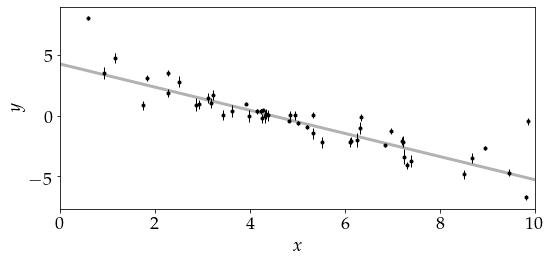

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8,4), tight_layout=True)

ax.errorbar(x, y, yerr=yerr, fmt='.k', capsize=0, lw=1)

x0 = np.linspace(0, 10, 500)
ax.plot(x0, a_true + b_true*x0, 'k', alpha=0.3, lw=3)
ax.set(xlim=(0,10), xlabel='$x$', ylabel='$y$');

fig.savefig('linear-model.pdf')

## Maximum Likelihood

Fit with a Gaussian log-likelihood that includes the fractional underestimate in the variance of each point:

$$
\ln{\mathcal{L}} = \ln{p(y|a,b,f)} =
-\frac{1}{2}\sum_{i=1}^N \left[\left(\frac{y_i-a-bx_i}{s_i}\right)^2 + \ln{(2\pi s_i^2)}\right],
$$
where

$$
s_i^2 = \sigma_i^2 + f^2(a + bx_i)^2.
$$
Note that in the log-likelihood the model parameter will actually be $\ln{f}$.

### Priors

Choose uniform priors $a\in[0,10]$, $b\in[-5,0.5]$, and $\ln{f}\in[-10,1]$.

In [4]:
# log-likelihood
def loglike(theta):
    a, b, lnf = theta
    model = a + b*x
    inv_sigma2 = 1.0 / (yerr**2 + model**2 * np.exp(2 * lnf))
    
    return -0.5 * (np.sum((y-model)**2 * inv_sigma2 - np.log(inv_sigma2)))

# prior transform
def prior_transform(utheta):
    ua, ub, ulf = utheta
    a = 10. * ua
    b = 5.5 * ub - 5.
    lnf = 11. * ulf - 10.
    
    return a, b, lnf

### Run the dynesty Sampler

In [5]:
dsampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim=3,
                                        bound='multi', sample='rstagger')
dsampler.run_nested()
dres = dsampler.results

21059it [03:17, 106.44it/s, batch: 9 | bound: 204 | nc: 25 | ncall: 486438 | eff(%):  4.329 | loglstar: -18.554 < -12.192 < -12.942 | logz: -23.533 +/-  0.191 | stop:  0.933]        


### Trace Plots

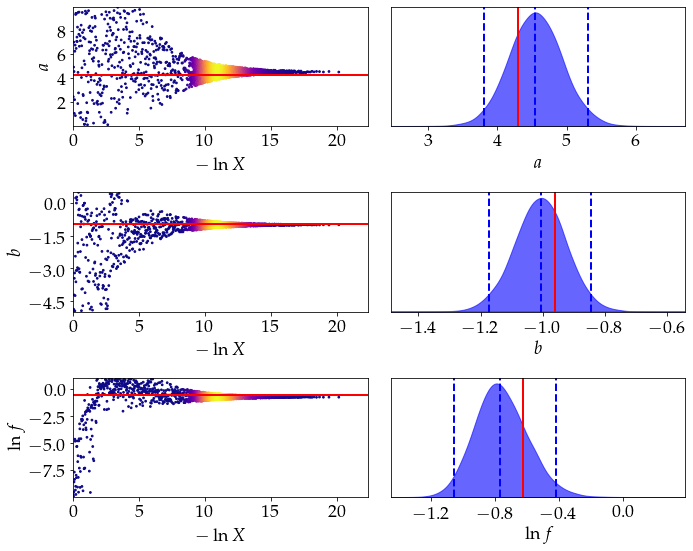

In [13]:
truths = [a_true, b_true, np.log(f_true)]
labels = [r'$a$', r'$b$', r'$\ln f$']
fig, axes = dyplot.traceplot(dsampler.results, truths=truths, labels=labels,
                             fig=plt.subplots(3, 2, figsize=(10,8)),
                             thin=10)
fig.tight_layout();

fig.savefig('linear-model-traceplot.pdf')

### Corner Plot

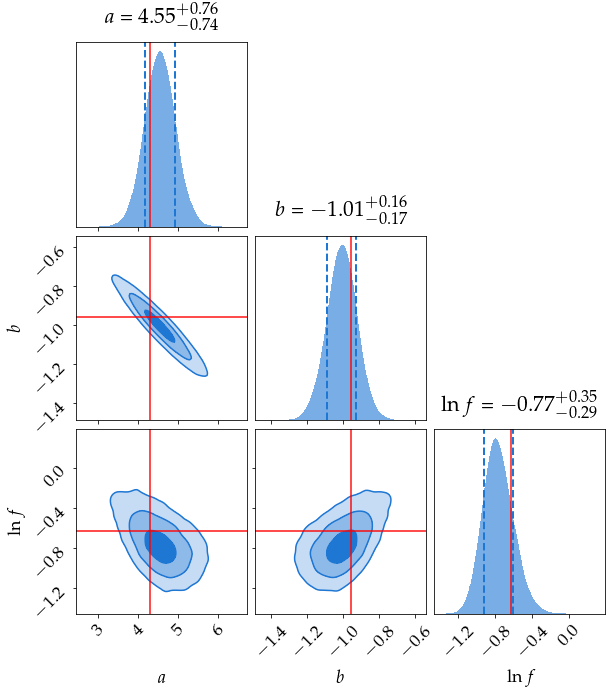

In [18]:
fig, axes = dyplot.cornerplot(dres, truths=truths, show_titles=True, 
                              title_kwargs={'y': 1.04}, labels=labels,
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1.,2.,3.]],
                              quantiles=(0.16, 0.84),
                              fig=plt.subplots(3, 3, figsize=(9,10)),
                              color='#1f77d4')

fig.subplots_adjust(top=0.925)
fig.savefig('linear-model-corner.pdf')

In [19]:
dres

         niter: 21059
         ncall: array([1, 1, 1, ..., 1, 1, 1])
           eff: 4.329225923961532
       samples: array([[ 2.45130592, -4.92762093, -9.73436754],
       [ 0.07737514, -4.53347747, -7.51951749],
       [ 1.93054717, -4.75178425, -8.11934229],
       ...,
       [ 4.50980013, -0.99877919, -0.78149855],
       [ 4.53650415, -1.00424823, -0.79636134],
       [ 4.53078816, -1.0038748 , -0.78513436]])
    samples_id: array([ 79,  28, 271, ...,  92, 455, 287])
 samples_batch: array([0, 0, 0, ..., 0, 0, 0])
    samples_it: array([   0,    0,    0, ..., 7060, 7774, 7937])
     samples_u: array([[0.24513059, 0.01315983, 0.02414841],
       [0.00773751, 0.08482228, 0.22549841],
       [0.19305472, 0.04513014, 0.17096888],
       ...,
       [0.45098001, 0.72749469, 0.83804559],
       [0.45365042, 0.72650032, 0.83669442],
       [0.45307882, 0.72656822, 0.83771506]])
     samples_n: array([500, 500, 500, ...,   3,   2,   1])
         logwt: array([-2.16662419e+05, -2.15474772

In [20]:
help(dres)

Help on Results in module dynesty.results object:

class Results(builtins.dict)
 |  Contains the full output of a run along with a set of helper
 |  functions for summarizing the output.
 |  
 |  Method resolution order:
 |      Results
 |      builtins.dict
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __delattr__ = __delitem__(self, key, /)
 |  
 |  __getattr__(self, name)
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  __setattr__ = __setitem__(self, key, value, /)
 |  
 |  summary(self)
 |      Return a formatted string giving a quick summary
 |      of the results.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from builtins.dict:
 | 

In [24]:
dres.logz, dres.logzerr

(array([-2.16662419e+05, -2.15474772e+05, -2.07395329e+05, ...,
        -2.35706885e+01, -2.35706714e+01, -2.35706544e+01]),
 array([0.1661668 , 0.16619088, 0.16621488, ..., 0.19017774, 0.19019982,
        0.19023758]))

In [25]:
print(dsampler.citations)

Code and Methods:
Speagle (2019): ui.adsabs.harvard.edu/abs/2019arXiv190402180S

Nested Sampling:
Skilling (2004): ui.adsabs.harvard.edu/abs/2004AIPC..735..395S
Skilling (2006): projecteuclid.org/euclid.ba/1340370944

Dynamic Nested Sampling:
Higson et al. (2017b): ui.adsabs.harvard.edu/abs/2017arXiv170403459H

Bounding Method:
Feroz, Hobson & Bridges (2009): ui.adsabs.harvard.edu/abs/2009MNRAS.398.1601F

Sampling Method:
Skilling (2006): projecteuclid.org/euclid.ba/1340370944

